In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import random
from torch.utils.data import DataLoader

# import dataloader





# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [2]:
num_epochs = 500
batch_size = 32
log_interval = 10

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [5]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to split the dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



# print the size of the datasets
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Train size: 50000
Validation size: 10000


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

        

In [3]:
# print the architecture of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:


import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    # normalize x to be between 0 and 1 and remove negative values
    x = F.relu(x)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [ ]:
from skimage.metrics import structural_similarity as ssim

# compute the mean squared error and the ssim score
def compute_mse(x, recon_x):
    x = F.relu(x)
    mse_loss = F.mse_loss(x, recon_x, reduction='sum')
    return mse_loss


def compute_ssim(x, recon_x):
    # Permute to (batch, height, width, channels) for SSIM
    x = x.permute(0, 2, 3, 1)  # Convert to (batch, height, width, channels)
    recon_x = recon_x.permute(0, 2, 3, 1)
    
    # Apply ReLU activation to ensure non-negative values
    x = F.relu(x)
    recon_x = F.relu(recon_x)

    # Calculate SSIM with a specified win_size
    ssim_loss = 1 - ssim(
        x.detach().cpu().numpy(),
        recon_x.detach().cpu().numpy(),
        data_range=1,
        multichannel=True,
        win_size=7,  
        channel_axis=-1  # Last dimension is channels
    )
    return ssim_loss


In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    mse_loss = 0
    ssim_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        mse = compute_mse(data, recon_batch)
        ssim = compute_ssim(data, recon_batch)
        
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        ssim_loss += ssim
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset), mse_loss / len(train_loader.dataset), ssim_loss / len(train_loader.dataset)


In [11]:
def test(epoch):
    model.eval()
    test_loss = 0
    mse_loss = 0
    ssim_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):
            data = data.to(device)
            model.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            mse = compute_mse(data, recon_batch)
            ssim = compute_ssim(data, recon_batch)
            mse_loss += mse.item()
            ssim_loss += ssim
            

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 64, 64)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, mse_loss / len(val_loader.dataset), ssim_loss / len(val_loader.dataset)


In [12]:
import time
if __name__ == "__main__":
    train_losses = []
    test_losses = []
    mse_losses = []
    ssim_losses = []
    test_mse_losses = []
    test_ssim_losses = []
    epochs = []
    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        train_loss, mse_loss, ssim_loss = train(epoch)
        train_losses.append(train_loss)
        mse_losses.append(mse_loss)
        ssim_losses.append(ssim_loss)
        test_loss, mse_loss, ssim_loss = test(epoch)
        test_losses.append(test_loss)
        test_mse_losses.append(mse_loss)
        test_ssim_losses.append(ssim_loss)
        epochs.append(epoch)


        with torch.no_grad():
            sample = torch.randn(64,1024, 1, 1).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample.view(64, 3, 64, 64),
                       'results/sample_' + str(epoch) + '.png')
    end_time = time.time()
    print(f"Training time: {end_time - start_time}s")

Train Epoch: 1 [0/50000 (0%)]	Loss: 8559.193359
Train Epoch: 1 [320/50000 (1%)]	Loss: 6746.092773
Train Epoch: 1 [640/50000 (1%)]	Loss: 6917.154785
Train Epoch: 1 [960/50000 (2%)]	Loss: 5461.156738
Train Epoch: 1 [1280/50000 (3%)]	Loss: 5385.729004
Train Epoch: 1 [1600/50000 (3%)]	Loss: 4871.119629
Train Epoch: 1 [1920/50000 (4%)]	Loss: 5195.903320
Train Epoch: 1 [2240/50000 (4%)]	Loss: 4892.139648
Train Epoch: 1 [2560/50000 (5%)]	Loss: 4330.350098
Train Epoch: 1 [2880/50000 (6%)]	Loss: 4646.837891
Train Epoch: 1 [3200/50000 (6%)]	Loss: 3826.711426
Train Epoch: 1 [3520/50000 (7%)]	Loss: 4656.083496
Train Epoch: 1 [3840/50000 (8%)]	Loss: 4129.352051
Train Epoch: 1 [4160/50000 (8%)]	Loss: 3917.794922
Train Epoch: 1 [4480/50000 (9%)]	Loss: 4201.520508
Train Epoch: 1 [4800/50000 (10%)]	Loss: 3671.569336
Train Epoch: 1 [5120/50000 (10%)]	Loss: 4407.917480
Train Epoch: 1 [5440/50000 (11%)]	Loss: 4113.118652
Train Epoch: 1 [5760/50000 (12%)]	Loss: 3797.502686
Train Epoch: 1 [6080/50000 (12%)]

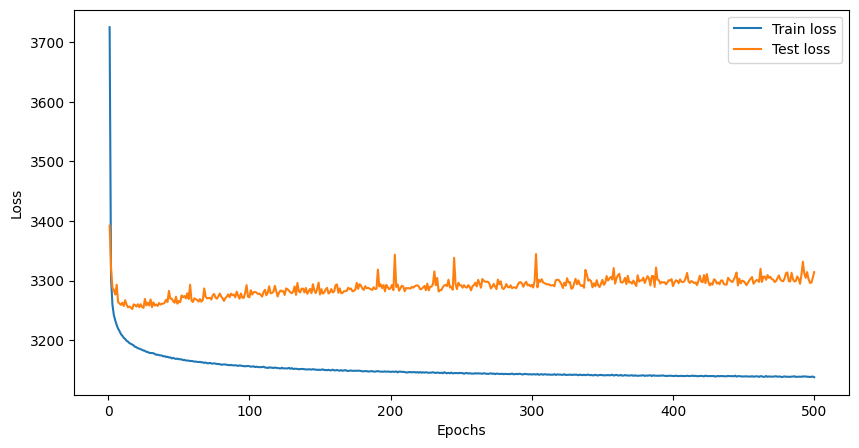

In [13]:
# plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, test_losses, label="Test loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

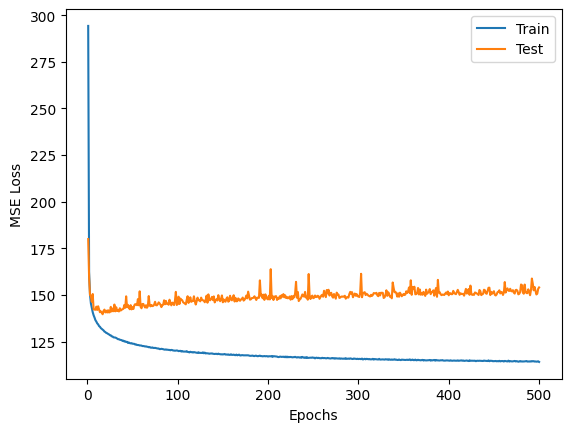

In [14]:
# plot the mse train and test loss over the epochs
import matplotlib.pyplot as plt
plt.plot(epochs, mse_losses, label='Train')
plt.plot(epochs, test_mse_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

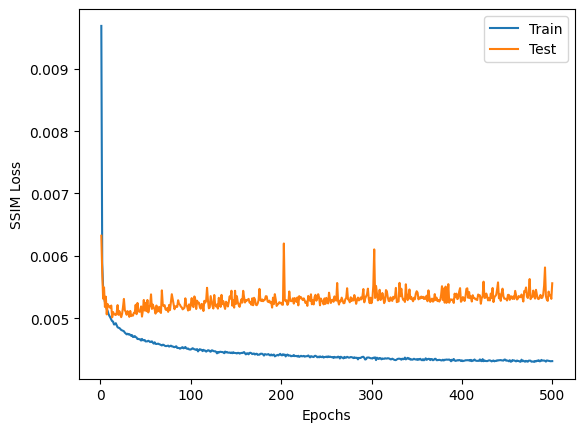

In [15]:
# plot the ssim train and test loss over the epochs
plt.plot(epochs, ssim_losses, label='Train')
plt.plot(epochs, test_ssim_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('SSIM Loss')
plt.legend()
plt.show()


In [16]:
# save the model
torch.save(model.state_dict(), "modelVAE.pth")